# Simple ARIMA Model for Non-Seasonal Time-Series Forecast

Our goal in this challenge is to apply the basic concepts of time series analysis to one-dimension data

In this challenge, we'll go through the following steps : 
1. load and visualize the data;
2. train our models and make predictions;

##  1. Load Data
Let's start by loading the Time Series of the challenge. Run the line below to download the dataset as a CSV file, then load the CSV in a DataFrame.

In [1]:
!curl https://wagon-public-datasets.s3.amazonaws.com/05-Machine-Learning/09-Time-Series/www_usage.csv > data/www_usage.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   377  100   377    0     0   2015      0 --:--:-- --:--:-- --:--:--  2026


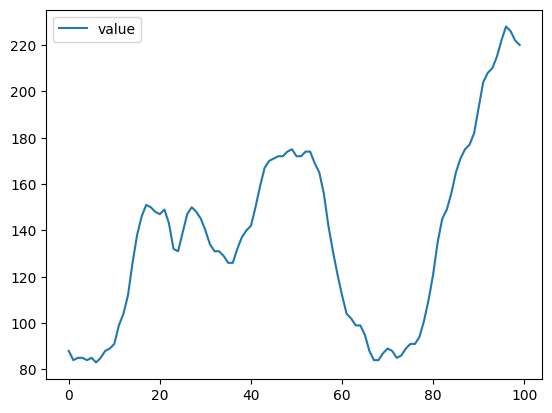

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('data/www_usage.csv', names=['value'], header=0)
y = df.value

df.plot();

This abstract time series does not seem seasonal, but with some increasing trend and somehow "sticky" (i.e. with some auto-regressivity). So it may be a good candidate for Auto-Regressive Moving Average (ARIMA) models.


## 2. Build ARIMA Model
We will try to forecast the data thanks to ARIMA models (Auto Regressive Integrated Moving Average).

For that, we will need to :
1. find how to stationarize the time series (I in SARIMA)
2. find the auto-regressive (AR) part
3. find the moving average (MA) part
4. Fit
5. Assess performance

### Step 1 - Ensure Stationarity

ARIMA models apply to "stationary" time series only.

👉 Check its stationarity precisely using the [`Augmented Dick Fuller test`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html), and especially its p-value

In [3]:
from statsmodels.tsa.stattools import adfuller

adfuller(df.value)

(-2.4642397172033674,
 0.12441935447109487,
 3,
 96,
 {'1%': -3.5003788874873405,
  '5%': -2.8921519665075235,
  '10%': -2.5830997960069446},
 444.67104090432554)

In [4]:
adfuller(df.value)[1]

0.12441935447109487

The p-value should be less than 0.05 to have a 95% confidence in the stationarity.  
If the p-value is larger than 0.05, we cannot reject the null hypothesis (null hypothesis = "the process is not stationary").

If the time series is not stationary, it needs to be stationarized through **differencing**. 
- It means that we take the difference between each value and the preceding one (*first difference*).
- Repeat the process on the differentiated series if you want the *second difference*, etc...

👉 Find the minimum order of differencing we need to make it stationary (plot the curves to visualize them, and print their adfuller p-value to be sure)

<details>
    <summary>Hint</summary>

`pd.Series.diff`
</details>

In [13]:
df.value

0      88
1      84
2      85
3      85
4      84
     ... 
95    222
96    228
97    226
98    222
99    220
Name: value, Length: 100, dtype: int64

In [16]:
df.diff(1)

,value
0,NaN
1,-4.0
2,1.0
3,0.0
4,-1.0
...,...
95,7.0
96,6.0
97,-2.0
98,-4.0


In [12]:
df.value.diff(1)

0     NaN
1    -4.0
2     1.0
3     0.0
4    -1.0
     ... 
95    7.0
96    6.0
97   -2.0
98   -4.0
99   -2.0
Name: value, Length: 100, dtype: float64

Text(0.5, 1.0, '2nd Order Differencing')

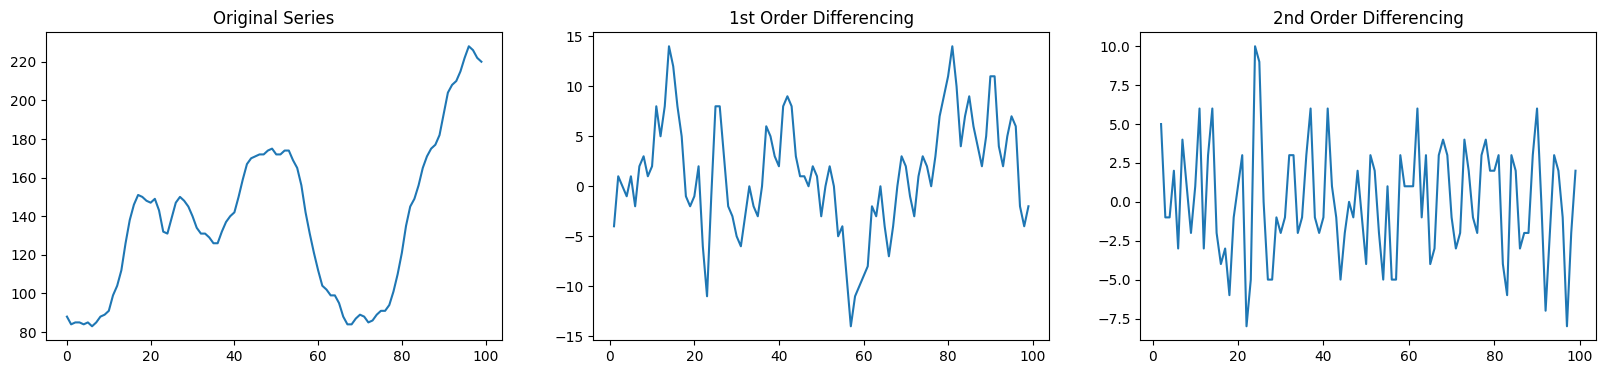

In [5]:
zero_diff = df.value
first_order_diff = df.value.diff(1)
second_order_diff = df.value.diff(1).diff(1)


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,4))
ax1.plot(zero_diff); ax1.set_title('Original Series')
ax2.plot(first_order_diff); ax2.set_title('1st Order Differencing')
ax3.plot(second_order_diff); ax3.set_title('2nd Order Differencing')

We have a close call here between one and two diff orders. Differentiating time series too much may also reduce the performance of your ARIMA models. Let's have a closer look:

👉 Plot autocorrelation plot ([`plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)) for diff order 1 and 2.

(💡Pro tip: Avoid duplicating statsmodels plots by calling `plt.show()` or by adding `;` to the end of each instantiation of a statsmodels plot)

<Figure size 1000x600 with 0 Axes>

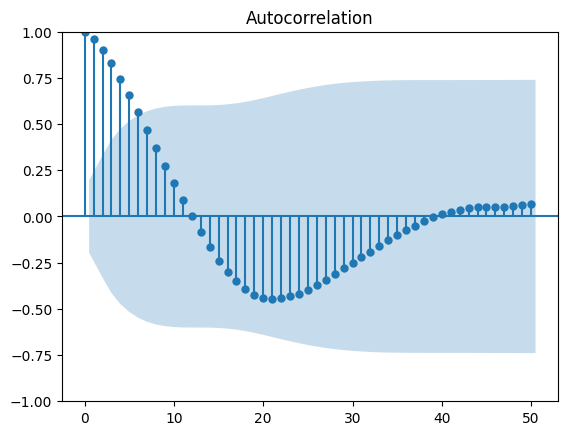

In [20]:
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(10, 6))
plot_acf(df.value, lags=50)
plt.show()

<Figure size 1000x600 with 0 Axes>

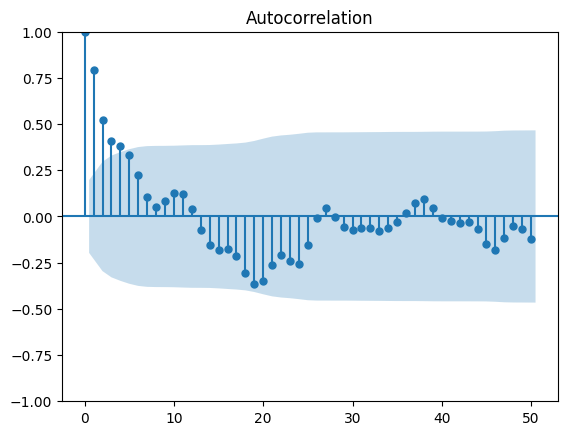

In [22]:
plt.figure(figsize=(10, 6))
plot_acf(df.value.diff(1).dropna(), lags=50)
plt.show()

<Figure size 1000x600 with 0 Axes>

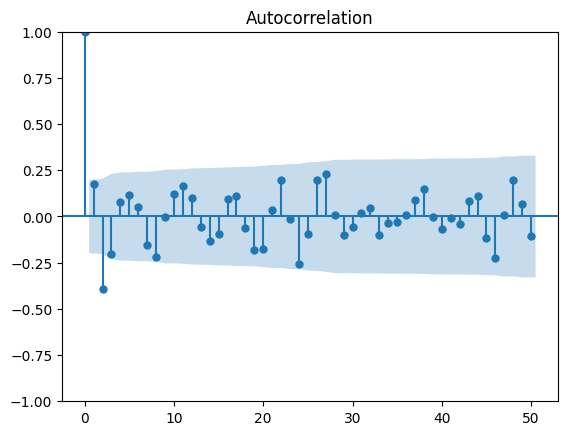

In [23]:
plt.figure(figsize=(10, 6))
plot_acf(df.value.diff(1).diff(1).dropna(), lags=50)
plt.show()

In our "second order diff" autocorrelation plot, the lag coefficient n°1 is close to 0, while the second one escapes far into negative territory. This might indicate we have over-differentiated the series. (Remember: we never care about the lag n°0 which is always equal to 1)

👉 Let's (tentatively) keep only one diff order and name this series `y_diff` (we can always try more diff later)

In [25]:
y_diff = y.diff().dropna()
y_diff

1    -4.0
2     1.0
3     0.0
4    -1.0
5     1.0
     ... 
95    7.0
96    6.0
97   -2.0
98   -4.0
99   -2.0
Name: value, Length: 99, dtype: float64

We just found the term "I" in ARIMA: `d = 1` for 1-diff before stationary ("I" refers to "integration", "d" for differentiation...)


### Step 2 - Select AR order (p) and MA order (q)

#### MA($\color{blue}{q}$) = number of lag beyond which the $\color{blue}{ACF}$ of  $Y^{\color{green}{(d)}}$ cuts off

MA order (`q`) can be found by looking at the autocorrelation plot ([`plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)) applied to`y_diff`. 

👉 determine `q`

In [26]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

<Figure size 640x480 with 0 Axes>

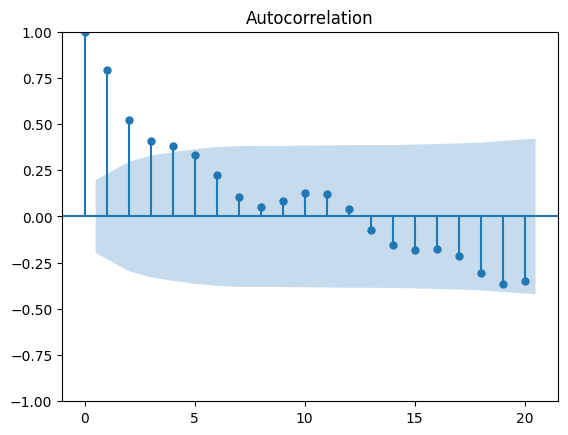

In [28]:
plt.figure()
plot_acf(y_diff)
plt.show()

The maximum value we should consider for fitting our model seems to be q = 4. However, if we were to use Auto-ARIMA (more on this later) we would find that using q=2 yields ideal results so to begin with, let's try setting q=2. 

When in doubt, go with the simpler model that sufficiently explains the Y.

#### AR($\color{red}{p}$) = number of lags beyond which the $\color{red}{PACF}$ of $Y^{\color{green}{(d)}}$  cuts off

AR order (`p`) can be found by investigating the **p**artial autocorrelation plot [`plot_pacf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html) applied to `y_diff`.

(Partial autocorrelation can be imagined as the correlation between the series and its lag, after excluding the contributions from the intermediate lags. So, PACF sort of conveys the pure correlation between a lag and the series)

👉 Determine `p`

/home/raphaelsisso/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 640x480 with 0 Axes>

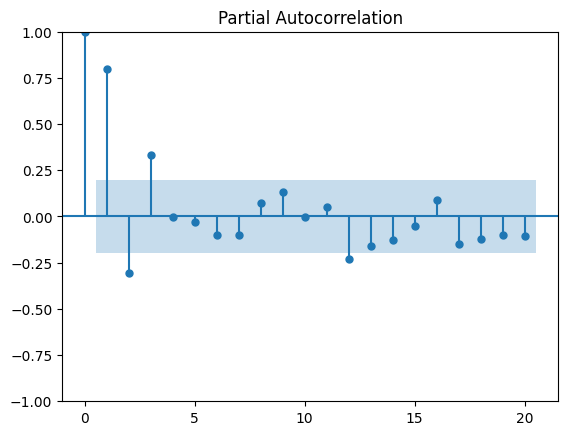

In [29]:
plt.figure()
plot_pacf(y_diff)
plt.show()

We could choose `p = 3` as the first 3 lag terms seem above the significance level, but we could also go with a simpler model `p = 1`. 



### Step 3 - Build the model

Now that you have chosen the values for `p`, ` d`, and `q` for the ARIMA, 

👉 build the `arima_model` from `statsmodels`.
- fit the model
- print the model (`.summary`)

In [58]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(df.value, order=(2, 1, 1))
arima_model = arima_model.fit()
arima_model.summary()

/home/raphaelsisso/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  100
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -254.146
Date:                Thu, 09 Jan 2025   AIC                            516.292
Time:                        12:12:37   BIC                            526.673
Sample:                             0   HQIC                           520.492
                                - 100                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6368      0.218      2.927      0.003       0.210       1.063
ar.L2          0.0143      0.198      0.072      0.942      -0.374       0.402
ma.L1          0.5353      0.179      2.999      0.003       0.185       0.885
sigma2         9.7928      1.411      6.938      0.000       7.026      12.559
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.11
Prob(Q):                              0.88   Prob(JB):                         0.95
Heteroskedasticity (H):               0.63   Skew:                            -0.08
Prob(H) (two-sided):                  0.19   Kurtosis:                         3.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

☝️ If your p-values are too high, try to remove these terms by reducing the corresponding AR or SA coefficients.

You can evaluate the overall performance of your fit by minimizing the [`AIC - Akaike Information Criterion`](https://towardsdatascience.com/the-akaike-information-criterion-c20c8fd832f2) value

In [48]:
import pmdarima as pm
smodel = pm.auto_arima(df.value, d=1,
                       start_p=1, max_p=2,
                       start_q=1, max_q=2,
                       trend='t',
                       seasonal=False,
                       trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=515.275, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=626.565, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=530.715, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=547.360, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=626.565, Time=0.29 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=517.273, Time=0.58 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=517.265, Time=1.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=519.271, Time=0.41 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=522.937, Time=0.18 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=518.537, Time=3.00 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=515.275, Time=0.20 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 6.697 seconds


It seems that the (1,1,1) ARIMA models have less chance of overfitting (p-values remain low) and maintain a quasi-similar AIC score than other models

## 3. Evaluate model performance

👉 Visualize your model predictions with the `plot_predict()` method

- Look closely at the method default params, especially `dynamic` ones. 
- Do you think your model would have such a good performance in reality?

In [53]:
df.shape

(100, 1)

In [36]:
from statsmodels.graphics.tsaplots import plot_predict

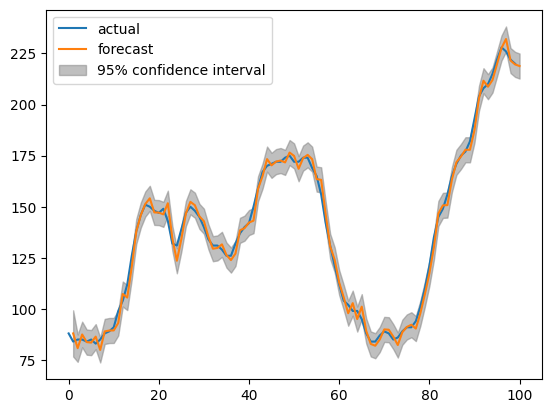

In [66]:
fig, axs = plt.subplots(1, 1)
axs.plot(df, label='actual')
plot_predict(arima_model, ax=axs, start=1, end=100)
plt.show()

☝️ `dynamic=False` makes use of all available values `y` to predict `y_pred`, making your ARIMA prediction use up to $y_{t-1}$ to predict $y_t$. In reality, you don't have access to all `y`, especially if you want to predict several intervals in the future.

👉 Try to use `dynamic=True` to plot a prediction of the _last 15 values_ in a situation where the model only has _access to data up to 85_. That is to say, the model:
- predicts 86 based on true [1...85]
- then predicts 87 based on [1...85] _plus_ its previously predicted value for 86
- etc...iteratively until 100

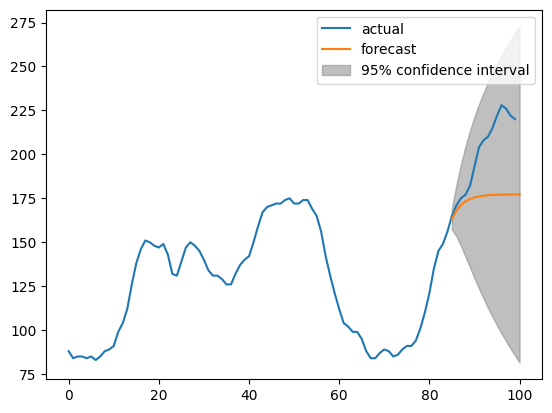

In [69]:
fig, axs = plt.subplots(1, 1)
axs.plot(df, label='actual')
plot_predict(arima_model, ax=axs, start=85, end=100, dynamic=True)
plt.show()

☝️ That's still not a _true_ forecast! Why?

<details>
    <summary>Answer</summary>

Our model has "seen" the whole `y_true` series during the fitting phase!
</details>

### 3.1 Out-of-Sample Forecasts (real "future")

👉 Create a train-test-split keep the last 15 data points only for the test set, and train your ARIMA on the train set only.

In [60]:
train_size = 0.85
index = round(train_size*df.shape[0])

df_train = df.iloc[:index]
df_test = df.iloc[index:]

arima = ARIMA(df_train.value, order=(2, 1, 1))
arima = arima.fit()

/home/raphaelsisso/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


👉 We are "now" in step 85 and have never seen the future:
- Use the `get_forecast()` method on your fitted `arima` model to "forecast" the 15 next data points (i.e beyond the end of your train dataset) 

The method returns a `PredictionResultsWrapper` object from `statsmodels`.

**💻 Store this result in a variable named `forecast_results`.**  

It is hard to navigate at first, but here are some tips:
- You can find your forecasts in `forecast_results.predicted_mean`
- Your confidence intervals are given by `forecast_results.conf_int()`

In [62]:
forecast_results = arima.get_forecast(len(df_test))
forecast_results

In [63]:
forecast_results.predicted_mean

85    163.127498
86    167.828973
87    171.042170
88    173.230638
89    174.721670
90    175.737498
91    176.429574
92    176.901082
93    177.222316
94    177.441172
95    177.590276
96    177.691860
97    177.761069
98    177.808220
99    177.840344
Name: predicted_mean, dtype: float64

In [72]:
conf_int = forecast_results.conf_int()
conf_int

,lower value,upper value
85,156.897717,169.357279
86,153.144338,182.513608
87,147.867722,194.216619
88,141.892983,204.568293
89,135.700077,213.743263
90,129.544295,221.930700
91,123.557678,229.301471
92,117.802733,235.999431
93,112.302777,242.141856
94,107.059424,247.822920


👉 Plot forecasted values as well as the higher and lower range of 95% uncertainty interval

👉 Try to also plot your previous 85 `y` real data points to better grasp model performance relative to the past

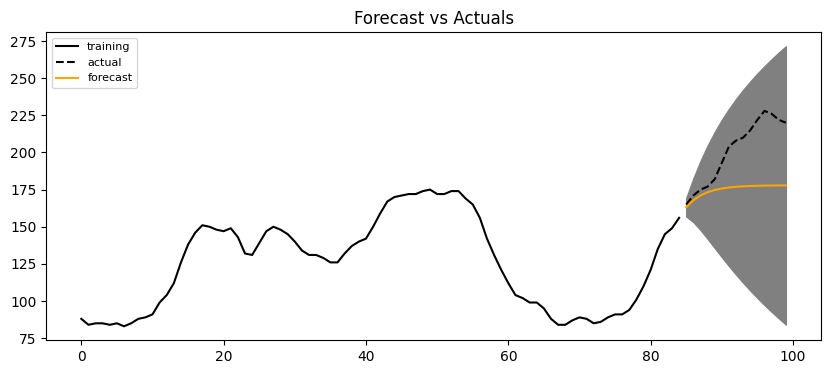

In [74]:
plt.figure(figsize=(10,4))
plt.plot(df_train, label='training', color='black')
plt.plot(df_test, label='actual', color='black', ls='--')
plt.plot(forecast_results.predicted_mean, label='forecast', color='orange')
plt.fill_between(conf_int['lower value'].index, conf_int['lower value'], conf_int['upper value'], color='grey')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8);

### 3.2 Can you trust your 95% confidence interval? (conditions for inference)

👉 Plot the residuals `model.resid` to ensure there are no patterns
- Normally distributed
- Mean zero
- Uniform variance
- No autoregressive patterns (you can plot_acf the residuals anyway if you want)

Note: residuals are constructed by 'seeing' all data as in `plot_predict(dynamic=False)`

Also, try to plot a histogram or KDE fit of the residuals to see if they are approximately normally distributed.

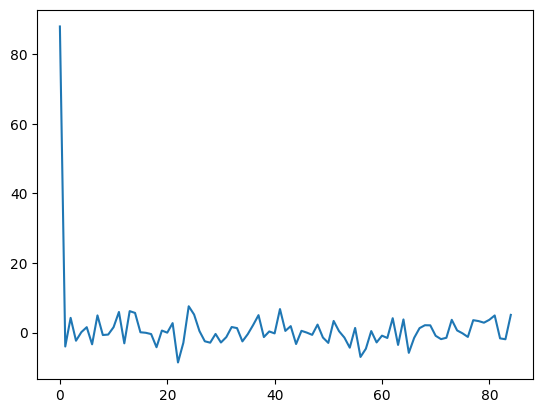

In [76]:
plt.plot(arima.resid)

(array([ 2.,  1.,  4., 12., 16., 18., 11., 10.,  7.,  3.]),
 array([-8.59652489, -6.98046115, -5.36439742, -3.74833369, -2.13226996,
        -0.51620622,  1.09985751,  2.71592124,  4.33198498,  5.94804871,
         7.56411244]),
 <BarContainer object of 10 artists>)

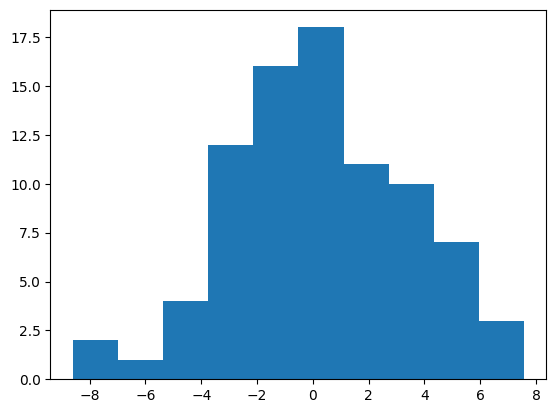

In [78]:
plt.hist(arima.resid[1:])

In [81]:
arima.resid[1:].mean()

0.23102841748229794

<Figure size 640x480 with 0 Axes>

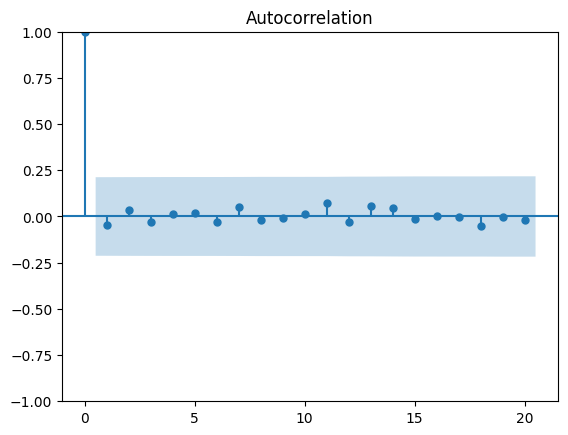

In [84]:
plt.figure()
plot_acf(arima.resid)
plt.show()

## 3.3 Cross-validated performance metrics

👉 Below are the most common performance metrics for time series

In [109]:
import numpy as np
from statsmodels.tsa.stattools import acf

def forecast_accuracy(y_pred: pd.Series, y_true: pd.Series) -> float:

    mape = np.mean(np.abs(y_pred - y_true)/np.abs(y_true))  # Mean Absolute Percentage Error
    me = np.mean(y_pred - y_true)             # ME
    mae = np.mean(np.abs(y_pred - y_true))    # MAE
    mpe = np.mean((y_pred - y_true)/y_true)   # MPE
    rmse = np.mean((y_pred - y_true)**2)**.5  # RMSE
    corr = np.corrcoef(y_pred, y_true)[0,1]   # Correlation between the Actual and the Forecast
    mins = np.amin(np.hstack([y_pred.values.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
    maxs = np.amax(np.hstack([y_pred.values.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(y_pred-y_true, fft=False)[1]                      # Lag 1 Autocorrelation of Error

    forecast = ({
        'mape':round(mape, 2),
        'me':round(me, 2),
        'mae': round(mae, 2),
        'mpe': round(mpe, 2),
        'rmse':round(rmse, 2),
        'acf1':round(acf1, 2),
        'corr':round(corr, 2),
        'minmax':round(minmax, 2)
    })

    return forecast

👉 Play with your ARIMA hyper-parameters and see the impact on your forecast performance

In [110]:
for i in range(1, 3):
    for j in range(1, 3):
        for k in range(1, 3):
            arima = ARIMA(df_train, order=(i, j, k))
            arima = arima.fit()
            y_pred = arima.predict(start=85, end=99, dynamic=False)
            print(f'forecast for hyperparams ({i}, {j}, {k}) :', forecast_accuracy(y_pred, df_test.value))

forecast for hyperparams (1, 1, 1) : {'mape': 0.13, 'me': -26.87, 'mae': 26.87, 'mpe': -0.13, 'rmse': 32.38, 'acf1': 0.87, 'corr': 0.85, 'minmax': 0.13}
forecast for hyperparams (1, 1, 2) : {'mape': 0.12, 'me': -25.04, 'mae': 25.04, 'mpe': -0.12, 'rmse': 30.26, 'acf1': 0.87, 'corr': 0.9, 'minmax': 0.12}
forecast for hyperparams (1, 2, 1) : {'mape': 0.09, 'me': 19.95, 'mae': 20.03, 'mpe': 0.09, 'rmse': 25.54, 'acf1': 0.69, 'corr': 0.96, 'minmax': 0.08}
forecast for hyperparams (1, 2, 2) : {'mape': 0.1, 'me': -20.94, 'mae': 20.94, 'mpe': -0.1, 'rmse': 25.53, 'acf1': 0.88, 'corr': 0.95, 'minmax': 0.1}


/home/raphaelsisso/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


forecast for hyperparams (2, 1, 1) : {'mape': 0.12, 'me': -26.38, 'mae': 26.38, 'mpe': -0.12, 'rmse': 31.8, 'acf1': 0.87, 'corr': 0.87, 'minmax': 0.12}
forecast for hyperparams (2, 1, 2) : {'mape': 0.1, 'me': -21.25, 'mae': 21.25, 'mpe': -0.1, 'rmse': 26.04, 'acf1': 0.88, 'corr': 0.94, 'minmax': 0.1}
forecast for hyperparams (2, 2, 1) : {'mape': 0.12, 'me': 26.33, 'mae': 26.33, 'mpe': 0.12, 'rmse': 32.06, 'acf1': 0.7, 'corr': 0.96, 'minmax': 0.11}
forecast for hyperparams (2, 2, 2) : {'mape': 0.12, 'me': 26.09, 'mae': 26.09, 'mpe': 0.12, 'rmse': 31.87, 'acf1': 0.7, 'corr': 0.96, 'minmax': 0.11}


## 4 Grid Search

Try to run a Grid Search for (p,d,q) using `pmdarima`. Use at least
- `test='adf'`
- `trace=True`
- `error_action='ignore'`
- `suppress_warnings=True`

In [112]:
import pmdarima as pm

model = pm.auto_arima(
    df_train.value,
    start_p=0, max_p=3,
    start_q=0, max_q=3,
    d=None,           # let model determine 'd'
    test='adf',       # using adf test to find optimal 'd'
    trace=True, error_action='ignore',  suppress_warnings=True
)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=449.662, Time=0.08 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=449.569, Time=0.09 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=445.819, Time=0.10 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=445.820, Time=0.09 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=441.300, Time=0.12 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=1.17 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=438.613, Time=0.55 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=440.036, Time=0.64 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=440.231, Time=0.41 sec

Best model:  ARIMA(0,2,3)(0,0,0)[0]          
Total fit time: 3.629 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   85
Model:               SARIMAX(0, 2, 3)   Log Likelihood                -215.307
Date:                Thu, 09 Jan 2025   AIC                   

## (Optional) Cross-validate the Performance of your Model

In practice, results and Grid Search should always be cross-validated: 

Feel free to use [`sklearn.TimeSeriesSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) to create contiguous K-folds to truly evaluate the performance of your model and find the best hyperparams after cross-validation.

<img src='https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_013.png'>

**ARIMA - Cross-Validation using TimeSeriesSplit + Grid Search**

In [ ]:
# YOUR CODE HERE

In [113]:
df.sort_values('AIC').groupby('(p, d, q)').mean()['AIC'].sort_values()

KeyError: 'AIC'

☝️ Our initial choice of model (1, 1, 2) is not so bad!
Notice that the dataset (100 data points) is in reality way too small to cross-validate anything!